In [1]:
import os
import nltk
import math
import random
import string
import pandas as pd
import seaborn as sns
from collections import deque
import matplotlib.pyplot as plt
from collections import Counter

from evaluate import load
from nltk.util import ngrams
from nltk import word_tokenize
from nltk import sent_tokenize
from nltk import edit_distance
from nltk.corpus import stopwords

## 1. Implementation of bigram and trigram language models
---

We are going to use the European Parliament Proceedings dataset, as offered by the `nltk` package:

In [2]:
# read europarl files into a list of lists (10 files = 10 lists)
corpus = []
data_dir = './europarl_raw/english/'
for file_id in os.listdir(data_dir):
    with open(data_dir + file_id, 'r', encoding='utf-8') as curr_file:
        corpus.append(curr_file.readlines())

The whole dataset consists of 10 different files. Hence, we will flatten and transform the corpus to a single string. Then, we tokenize it to sentence level:

In [3]:
# flatten corpus list into a single string
corpus = [word for file in corpus for word in file] 
corpus_raw = ''.join(corpus)

# tokenize corpus to sentences
sentences_tokenized = []
for sentence in sent_tokenize(corpus_raw):
    sentences_tokenized.append(sentence)

We divide our dataset to 80% training and 20% test. We do so at the sentence level:

In [4]:
# shuffle
random.shuffle(sentences_tokenized)
split_80 = len(sentences_tokenized) * 80 // 100

# split to train and test
test_sentences = sentences_tokenized[split_80:]
train_sentences = sentences_tokenized[:split_80]

Before tokenizing our training corpus to word level, we will remove stopwords:

In [5]:
# define stopword accumulator
stopwords_acc = string.punctuation

Using just the training corpus, we also define our dataset's vocabulary:

In [6]:
# vocabulary generation

acc = []
for sentence in train_sentences:
    acc += [word for word in word_tokenize(sentence)]
    
vocabulary = []
for key, value in dict(Counter(acc)).items():
    if value > 10 and key not in stopwords_acc and not key.isnumeric():
        vocabulary.append(key)

Last but not least, we tokenize training and test sets to word level. For the test set, we will replace OOV terms with the `UNK` token:

In [7]:
# tokenize sentences to word level, remove stopwords

train_sentences_tokenized = []
for sentence in train_sentences:
    curr = word_tokenize(sentence)
    curr = [word for word in curr if word not in stopwords_acc]
    curr_voc = []
    for word in curr:
        if word not in vocabulary:
            word = 'UNK'
        curr_voc.append(word)
    train_sentences_tokenized.append(curr_voc)
    
test_sentences_tokenized = []
for sentence in test_sentences:
    curr = word_tokenize(sentence)
    curr = [word for word in curr if word not in stopwords_acc]
    curr_voc = []
    for word in curr:
        if word not in vocabulary:
            word = 'UNK'
        curr_voc.append(word)
    test_sentences_tokenized.append(curr_voc)

For general perspective reasons, we provide the number of sentences, tokens and unique tokens in the training and test sets:

In [9]:
# summary statistics

print('Train | {} sentences, {} tokens, {} unique tokens'.
      format(
          len(train_sentences),
          len([word for sentence in train_sentences_tokenized for word in sentence]),
          len(set([word for sentence in train_sentences_tokenized for word in sentence]))
      )
)
print('Test  | 0{} sentences, 0{} tokens, {} unique tokens'.
      format(
          len(test_sentences),
          len([word for sentence in test_sentences_tokenized for word in sentence]),
          len(set([word for sentence in test_sentences_tokenized for word in sentence]))
      )
)

Train | 15928 sentences, 402417 tokens, 3120 unique tokens
Test  | 03982 sentences, 099645 tokens, 3059 unique tokens


For the training of the models, we will left-pad our n-grams with the the token `s` and right-pad them with the `e` token.

In [10]:
unigram_counter, bigram_counter, trigram_counter = Counter(), Counter(), Counter()

for sent in train_sentences_tokenized:
    unigram_counter.update(
        [gram for gram in ngrams(
            sent,
            1, 
            pad_left=True, 
            pad_right=True)
        ]
    )
    bigram_counter.update(
        [gram for gram in ngrams(
            sent,
            2, 
            pad_left=True, 
            pad_right=True, 
            left_pad_symbol='<s>',
            right_pad_symbol='<e>')
        ]
    )
    trigram_counter.update(
        [gram for gram in ngrams(
            sent, 
            3, 
            pad_left=True, 
            pad_right=True,
            left_pad_symbol='<s>',
            right_pad_symbol='<e>')
        ]
    )

For exploratory reasons, we visualize the top 20 occurencies of each model:

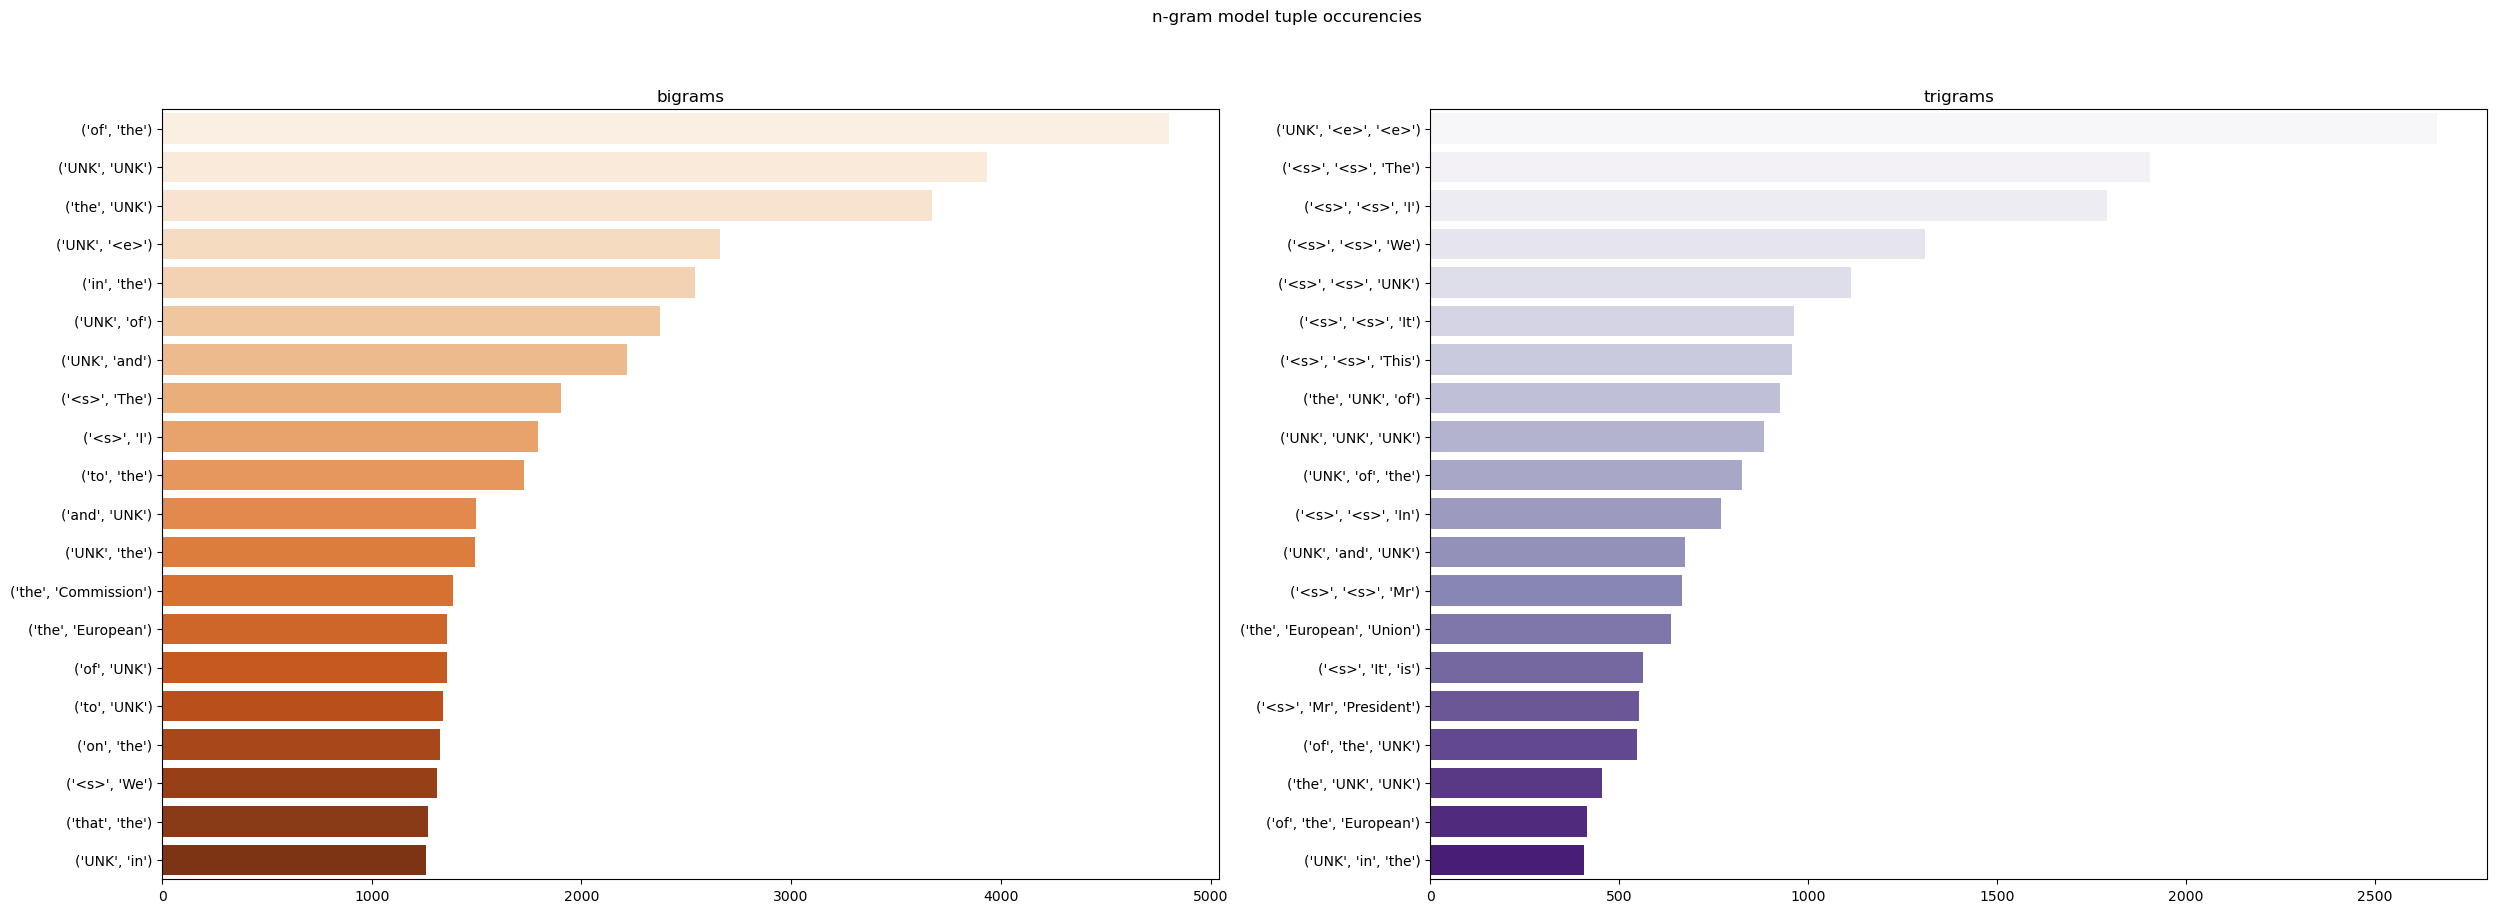

In [11]:
dfb = pd.DataFrame(bigram_counter.most_common(20), columns =['bigram', 'count'])
dft = pd.DataFrame(trigram_counter.most_common(20), columns =['trigram', 'count'])

sns.set_palette(sns.color_palette('BuPu'))
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
fig.suptitle('n-gram model tuple occurencies')
sns.barplot(ax=axes[0], data=dfb, x="count", y="bigram", palette="Oranges").set_title('bigrams')
sns.barplot(ax=axes[1], data=dft, x="count", y="trigram", palette='Purples').set_title('trigrams')
axes[0].set(xlabel='', ylabel='')
axes[1].set(xlabel='', ylabel='')
plt.show()

## 2. Calculating cross-entropy and perplexity
---

We will calculate the cross entropy and perplexity of the two models by implementing Laplace smoothing with `α=0.1`.

In [12]:
alpha = 0.1
vocabulary_size = len(vocabulary)

In [13]:
bigram_count = 0
probability_sum = 0

for sentence in test_sentences_tokenized:
    
    sentence = sentence + ['<e>'] # ignore <start> tokens

    for word in range(1, len(sentence)):
        bigram_probability = (bigram_counter[(sentence[word-1], sentence[word])] + alpha) / (unigram_counter[(sentence[word-1], )] + alpha*vocabulary_size)
        probability_sum += math.log2(bigram_probability)
        bigram_count += 1

cross_entropy = - probability_sum / bigram_count
perplexity = math.pow(2, cross_entropy)

print("Bigram cross entropy: {0:.2f}".format(cross_entropy))
print("Bigram perplexity: {0:.2f}".format(perplexity))

Bigram cross entropy: 7.07
Bigram perplexity: 134.20


In [14]:
trigram_count = 0
probability_sum = 0

for sentence in test_sentences_tokenized:
    
    sentence = sent + ['<e>'] + ['<e>'] # ignore <start> tokens

    for word in range(2, len(sent)-1):
        trigram_probability = (trigram_counter[(sentence[word-2], sentence[word-1], sentence[word])] + alpha) / (bigram_counter[(sentence[word-2], sentence[word-1])] + alpha*vocabulary_size)
        probability_sum += math.log2(trigram_probability)
        trigram_count += 1

cross_entropy = - probability_sum / trigram_count
perplexity = math.pow(2, cross_entropy)

print("Trigram cross entropy: {0:.2f}".format(cross_entropy))
print("Trigram perplexity: {0:.2f}".format(perplexity))

Trigram cross entropy: 7.22
Trigram perplexity: 149.05


We notice how the trigram models achieves slightly larger cross entropy and perplexity values, indicating lesser performance.

## 3. Context-aware spelling corrector
---

Our spelling corrector utilizes a queue data structure to predict potential corrections for a given sentence. At each step, the algorithm keeps the 10 most similar words to the input, including the original one and returns the most probable sentence according to the vocabulary given:

In [15]:
def spelling_corrector(sentence_tokenized, vocabulary=vocabulary, paths=1):
    
    sentence = ['<s>'] + sentence_tokenized + ['<e>']

    queue = deque()
    queue.append([sentence[0]])

    while queue:

        # get latest form of potential sentence and append the next-in-line word
        curr = queue.popleft() 
        sentence_index = len(curr)
        
        # if end-of-sentence is reached, terminate
        if sentence_index < len(sentence) and sentence[sentence_index] != '<e>':
            curr.append(sentence[sentence_index])
        else:
            break

        # calculate Levenshtein distances with every vocabulary token, work on the top 10 predictions
        levenshtein_acc = [(0, curr[-1])]
        for token in vocabulary:
            levenshtein_acc.append((edit_distance(token, curr[-1]), token))

        # calculate model probabilities among the predictions of the previous step
        probability_acc = []
        for canditate in sorted(levenshtein_acc)[:10]:
            probability = (bigram_counter[(curr[0], canditate[1])] + alpha) / (unigram_counter[(curr[-2], )] + alpha*vocabulary_size)
            probability_acc.append((probability, canditate[0], canditate[1]))

        # keep potential paths for the current state of the sentence (maximum probability, minimum Levenshtein)
        for path in sorted(probability_acc, key=lambda x: (-x[0], x[1]))[:paths]:
            current_string = curr.copy()
            current_string[-1] = path[2]
            queue.append(current_string)
        
    return curr[1:] # discard <s> token

## 4. Artificial test dataset
---

Before creating our artificial dataset, we will first separate the sentences with no `UNK` tokens in them:

In [16]:
known_test_sentences_tokenized = []
for sentence in test_sentences_tokenized:
    if 'UNK' in sentence:
        continue
    known_test_sentences_tokenized.append(sentence)

For the creation of the required test dataset, we will traverse our tokenized test sentences and replace 1 or 2 letters for every known word with a random letter:

In [17]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'

original_test_sentences_tokenized = []
artificial_test_sentences_tokenized = []
for sentence in known_test_sentences_tokenized:
    new_sentence = []
    for word in sentence:
        random_index = random.sample(range(len(word)), len(word)//5)
        curr_word = list(word)
        for index in random_index:
            curr_word[index] = random.choice(alphabet)
        new_word = ''.join(curr_word)
        new_sentence.append(new_word)
    if sentence != '': # discard empty strings
        original_test_sentences_tokenized.append(sentence)
        artificial_test_sentences_tokenized.append(new_sentence)

We display a couple examples from the above generation:

In [18]:
for index in range(3):
    print('Original: ' + ' '.join(original_test_sentences_tokenized[index]))
    print('Artificial: ' + ' '.join(artificial_test_sentences_tokenized[index]))
    print()

Original: We live in a world of rules and regulations let us regulate the Internet too and give our fellow citizens rules and hope for the future
Artificial: We live in a world of dules and tegulapions let us regslate the Interket too and give our fgllow citizeny gules and hope for the cuture

Original: Is there anyone who wishes to speak in favour of this proposal
Artificial: Is these anqone who wishes to spewk in fafour of this propolal

Original: Why should we add to them
Artificial: Why shojld we add to them



## 5. Spelling corrector evaluation
---

We will evaluate our spelling corrector by calculating WER (Word Error Rate) and CER (Character Error Rate) metrics:

In [29]:
cer = load('cer')
wer = load('wer')

references, predictions = [], []
for index in range(len(artificial_test_sentences_tokenized)):
    original = original_test_sentences_tokenized[index]
    predicted = spelling_corrector(artificial_test_sentences_tokenized[index])
    if ' '.join(original) != '': # discard empty original sentences
        references.append(' '.join(original))
        predictions.append(' '.join(predicted))

For reference we display a couple results the spelling corrector generates:

In [30]:
for index in range(3):
    print('Artificial: ' + references[index])
    print('Prediction: ' + predictions[index])
    print()

Artificial: We live in a world of rules and regulations let us regulate the Internet too and give our fellow citizens rules and hope for the future
Prediction: We Like In I world If Does And tegulapions Let As Despite The Indeed For And Like But Allow Citizens Does And Some For The Culture

Artificial: Is there anyone who wishes to speak in favour of this proposal
Prediction: I There anqone The either So New In Your If This Europol

Artificial: Why should we add to them
Prediction: The shojld We And So The



In [31]:
wer_score = wer.compute(predictions=predictions, references=references)
print('WER: {:.2%}'.format(wer_score))

WER: 91.26%


In [32]:
cer_score = cer.compute(predictions=predictions, references=references)
print('CER: {:.2%}'.format(cer_score))

CER: 28.88%


We notice how the WER is considerably higher than the CER achieved by our spelling corrector. This is expected considering that our algorithm is much more likely to predict a character for a word than a word for a sentence.